In [1]:
library(magrittr)
library(tibble)
library(quanteda)
library(dplyr)
library(ggplot2)
library(tidyr)

Package version: 3.2.4
Unicode version: 13.0
ICU version: 69.1

Parallel computing: 8 of 8 threads used.

See https://quanteda.io for tutorials and examples.


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:magrittr’:

    extract




In [2]:
list.files("books/")

[1] "ForWhomtheBellTolls.epub" "SunAlsoRises.epub"       
[3] "TheOldManandtheSea.epub"  "arms.txt"                
[5] "bell.txt"                 "pico.save"               
[7] "sun.txt"

In [3]:
#uploading books in order of creation
title1 <- "books/arms.txt"
title2 <- "books/sun.txt"
title3 <- "books/bell.txt"

newBook <- function(path, title) {
    book <- as_tibble(read.delim(path, quote = "", col.names="text")) %>%
        add_column(title = title)
    return(book)
}

book1 <- newBook(title3, "A Farewell To Arms")
book2 <- newBook(title1, "Sun Also Rises")
book3 <- newBook(title2, "For Whom the Bell Tolls")


In [4]:
books <- rbind(book1, book2, book3)
#sombine all books into a corpus
corpusOfBooks <- function(books) {
    df <- books %>%
        group_by(title) %>%
        summarise(text = paste(text, collapse = " ")) %>%
        corpus()
    
    return(df)
    }


In [5]:
library(quanteda.textplots)

#lets look at all the most common words in 3 books
corp <- corpusOfBooks(books)
summary(corp)

,Text,Types,Tokens,Sentences,title
,<chr>,<int>,<int>,<int>,<chr>
1,text1,10862,212129,15001,A Farewell To Arms
2,text2,5655,86429,8048,For Whom the Bell Tolls
3,text3,7001,112152,10011,Sun Also Rises


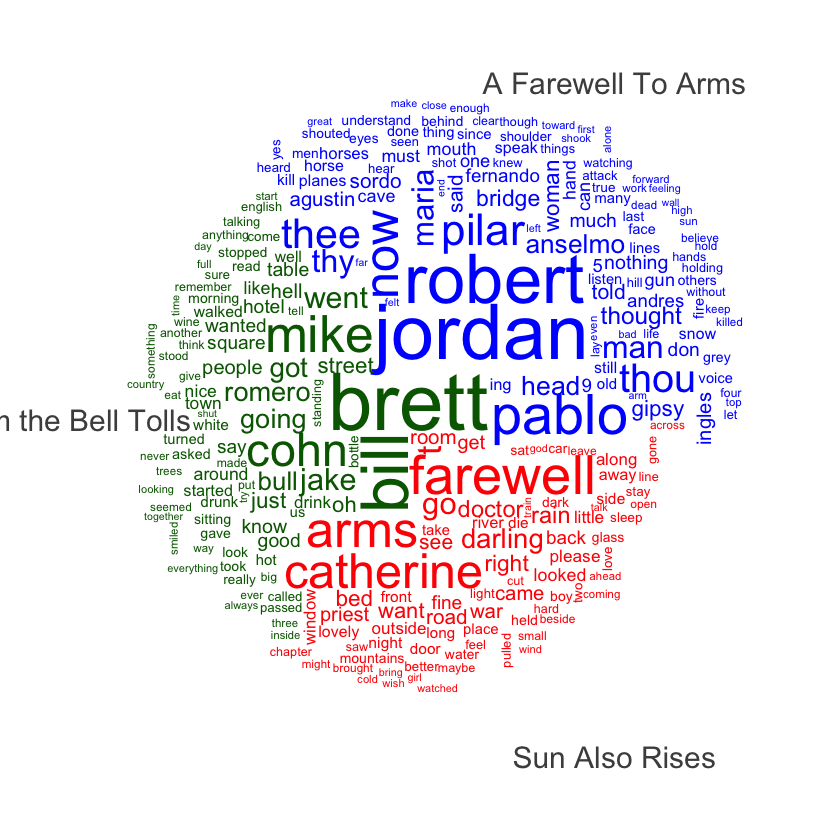

In [6]:
#most common words vs each book
corp %>%
  tokens(remove_punct = TRUE) %>%
  tokens_remove(stopwords("english")) %>%
  dfm() %>%
  dfm_group(groups = title) %>%
  textplot_wordcloud(min_count = 100, comparison = TRUE, color = c("blue", "darkgreen", "red"))

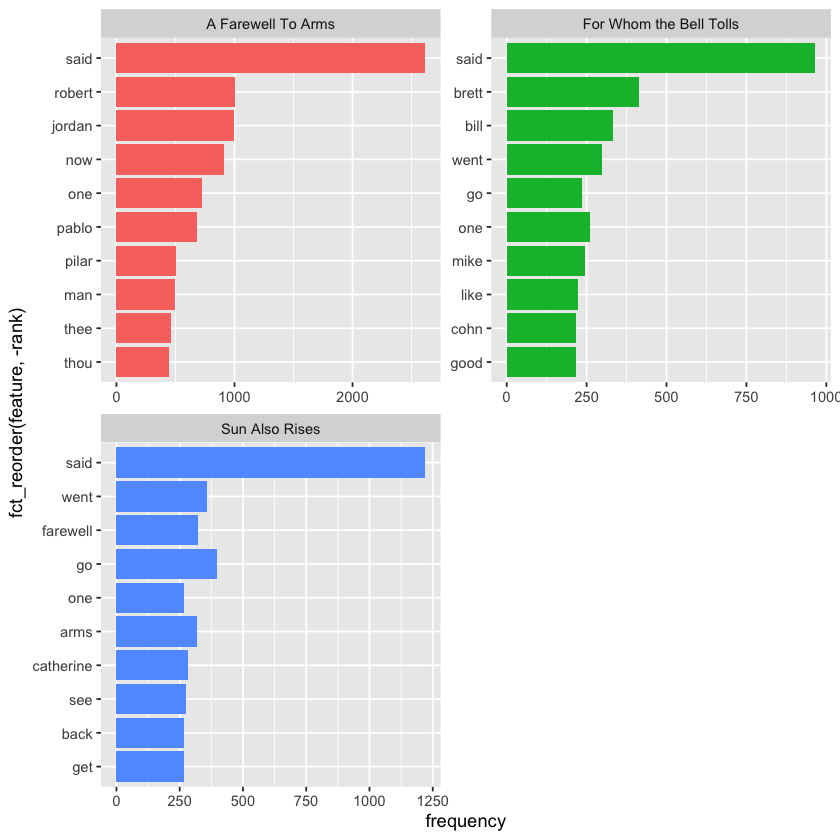

In [7]:
#most common words in each book
library(quanteda.textstats)
library(forcats)

corp %>% 
    tokens(remove_punct = TRUE) %>%
    tokens_remove(stopwords("english")) %>% 
    dfm() %>%
    textstat_frequency(n = 10, groups = title) %>%
    ggplot() + 
    geom_col(aes(x = frequency, y = fct_reorder(feature, -rank), fill = group), show.legend = F) + 
    facet_wrap(~group, scales = "free", nrow = 2)

Warning message:
“'texts.corpus' is deprecated.
Use 'corpus_group' instead.
See help("Deprecated")”


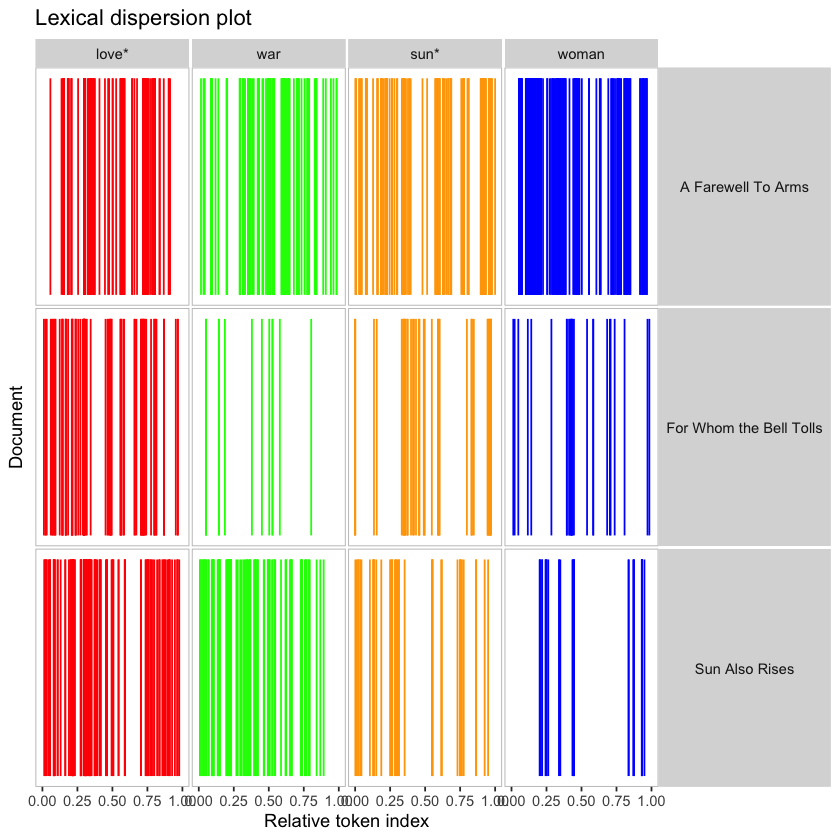

In [8]:
#when, and how often, words most associated whith Hemingway's writing appear
tokensCorp <- texts(corp, groups = title) %>% tokens()

g <- textplot_xray(
  kwic(tokensCorp, pattern = "love*", valuetype = "glob"),
  kwic(tokensCorp, pattern = "war"),
  kwic(tokensCorp, pattern = "sun*", valuetype = "glob"),
  kwic(tokensCorp, pattern = "woman")
)

g + aes(color = keyword) + 
  scale_color_manual(values = c("red", "green", "orange", "blue")) +
  theme(legend.position = "none")

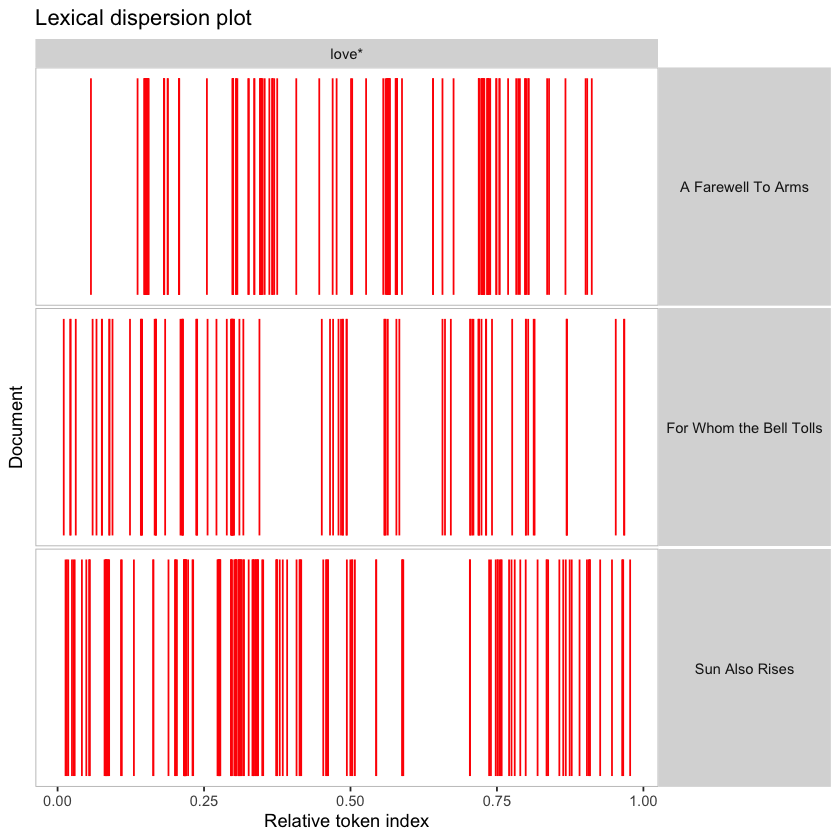

In [9]:
#lets take a look at love, and what it tells us about the action of 
g <- textplot_xray(
  kwic(tokensCorp, pattern = "love*", valuetype = "glob"))

g + aes(color = keyword) + 
  scale_color_manual(values = c("red")) +
  theme(legend.position = "none")

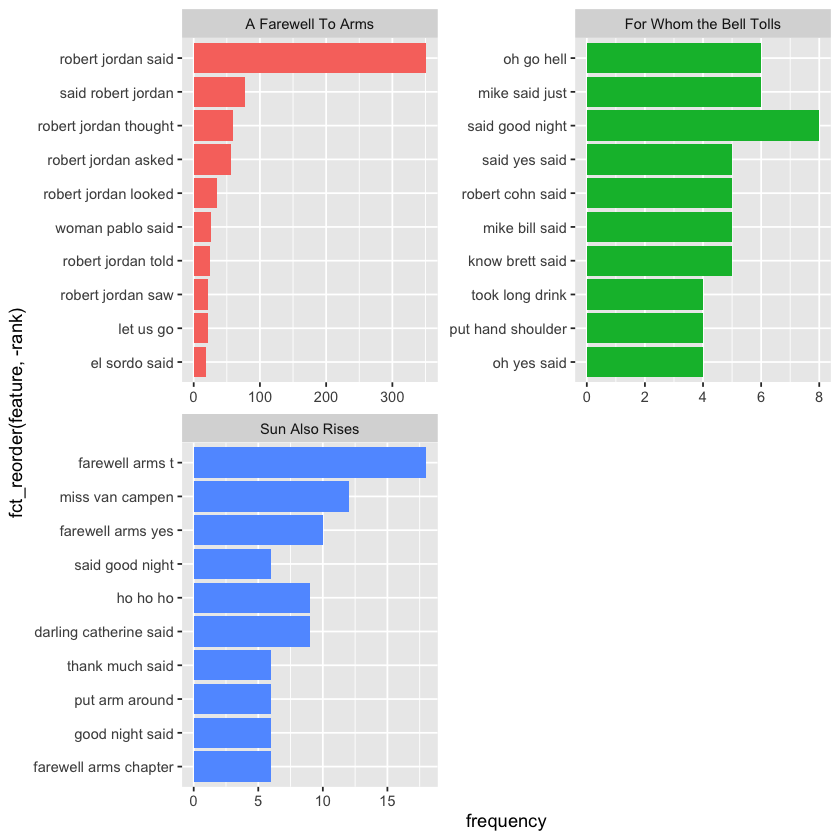

In [29]:
#most popular 3-grams
corp %>% 
    tokens(remove_punct = TRUE) %>%
    tokens_remove(stopwords("english")) %>% 
    tokens_ngrams(n = 3, concatenator = " ") %>%
    dfm() %>%
    textstat_frequency(n = 10, groups = title) %>%
    ggplot() + 
    geom_col(aes(x = frequency, y = fct_reorder(feature, -rank), fill = group), show.legend = F) + 
    facet_wrap(~group, scales = "free", nrow = 2)

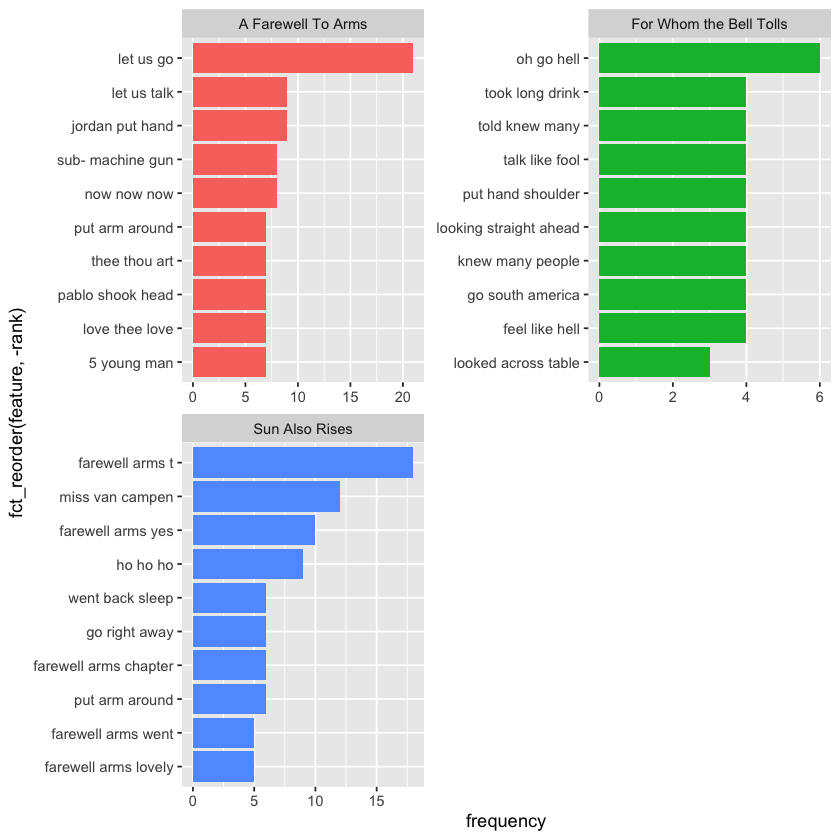

In [11]:
#most popular 3-grams without the word "said" and "robert".
corp %>% 
    tokens(remove_punct = TRUE) %>%
    tokens_remove(stopwords("english")) %>% 
    tokens_remove(c("said", "robert")) %>%
    tokens_ngrams(n = 3, concatenator = " ") %>%
    dfm() %>%
    textstat_frequency(n = 10, groups = title) %>%
    ggplot() + 
    geom_col(aes(x = frequency, y = fct_reorder(feature, -rank), fill = group), show.legend = F) + 
    facet_wrap(~group, scales = "free", nrow = 2)

In [12]:
library(tidytext)
library(textdata)
#lets check emotions in each book
hemingway_books <- books %>%
  group_by(title) %>%
  mutate(linenumber = row_number()) %>%
  ungroup() %>%
  unnest_tokens(word, text)

nrc <- get_sentiments("nrc")

In [13]:
pos_neg <- hemingway_books %>%
  inner_join(nrc) %>%
  filter(sentiment %in% c("positive", "negative")) %>%
  group_by(sentiment) %>%
  count(word, sort = T) %>%
  top_n(10, n) %>%
  ungroup() %>%
  mutate(word = reorder(word, n))

Joining, by = "word"


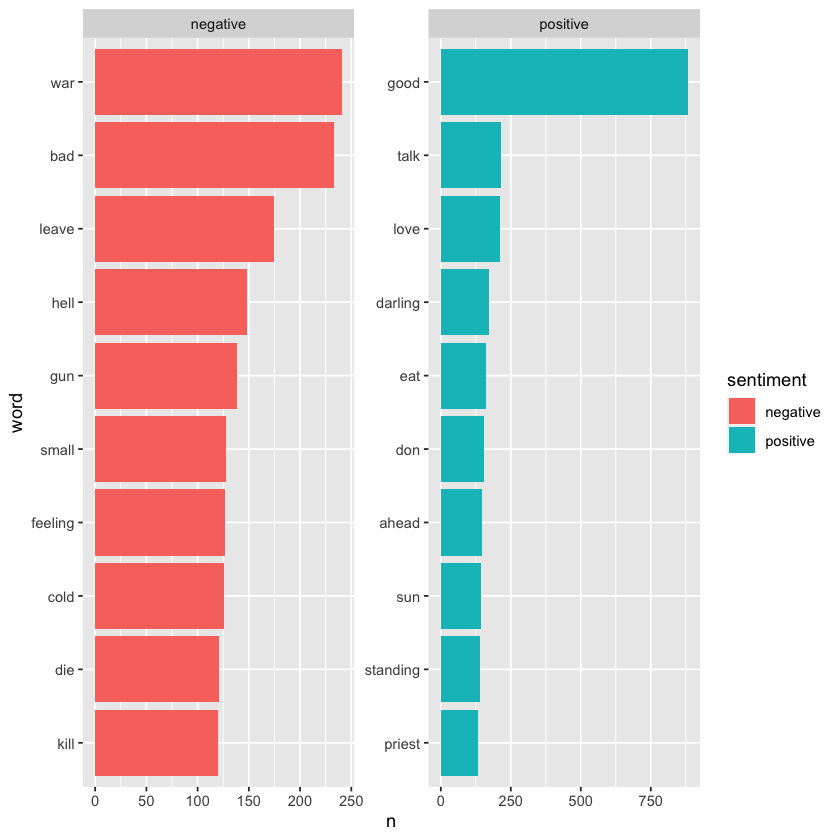

In [14]:
ggplot(pos_neg) + geom_col(aes(word, n, fill = sentiment)) + 
  coord_flip() + 
  facet_wrap( ~ sentiment, scales = "free")

In [15]:
nrc_class <- hemingway_books %>%
    filter(!word =="good") %>%
    inner_join(nrc) %>%
    filter(!(sentiment %in% c("positive", "negative"))) %>%
    group_by(sentiment) %>%
    count(word, sort = T) %>%
    top_n(10, n) %>%
    ungroup() %>%
    mutate(word = reorder(word, n))

Joining, by = "word"


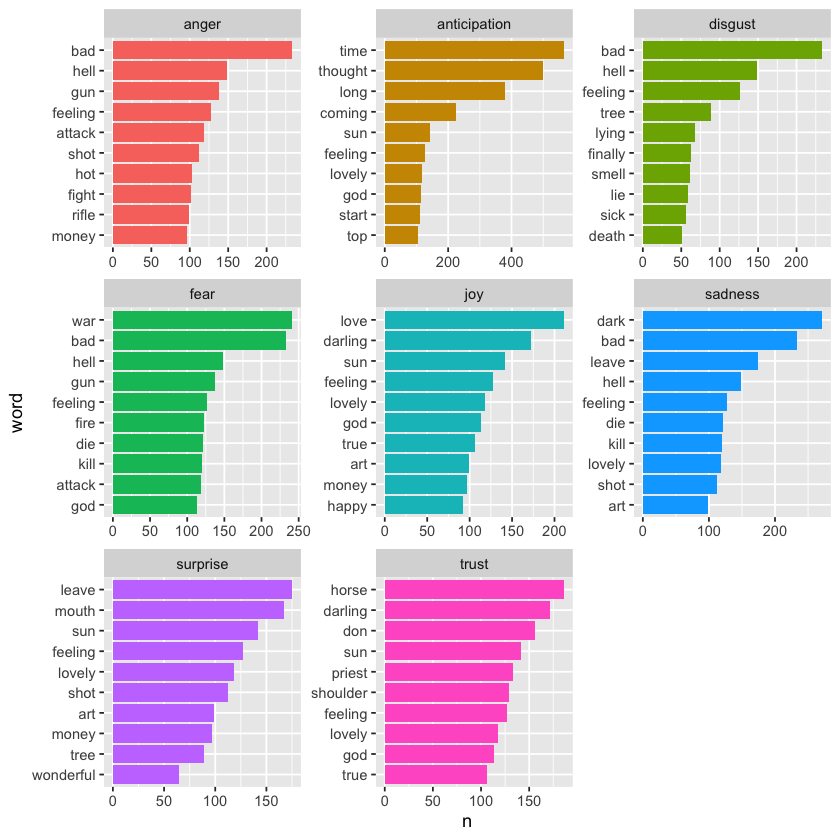

In [16]:
#lets loook at other emotions dropping word "good"
ggplot(nrc_class) + geom_col(aes(word, n, fill = sentiment), show.legend = FALSE) + 
  coord_flip() + 
  facet_wrap(~sentiment, nrow = 3, scales = "free")

In [17]:
#lets look at emotions in time in each book
hemingway_senti_bing <- hemingway_books %>%
    inner_join(get_sentiments("bing")) %>%
    count(title, index = linenumber %/% 80, sentiment) %>%
    spread(sentiment, n, fill = 0) %>%
    mutate(sentiment = positive - negative)

Joining, by = "word"


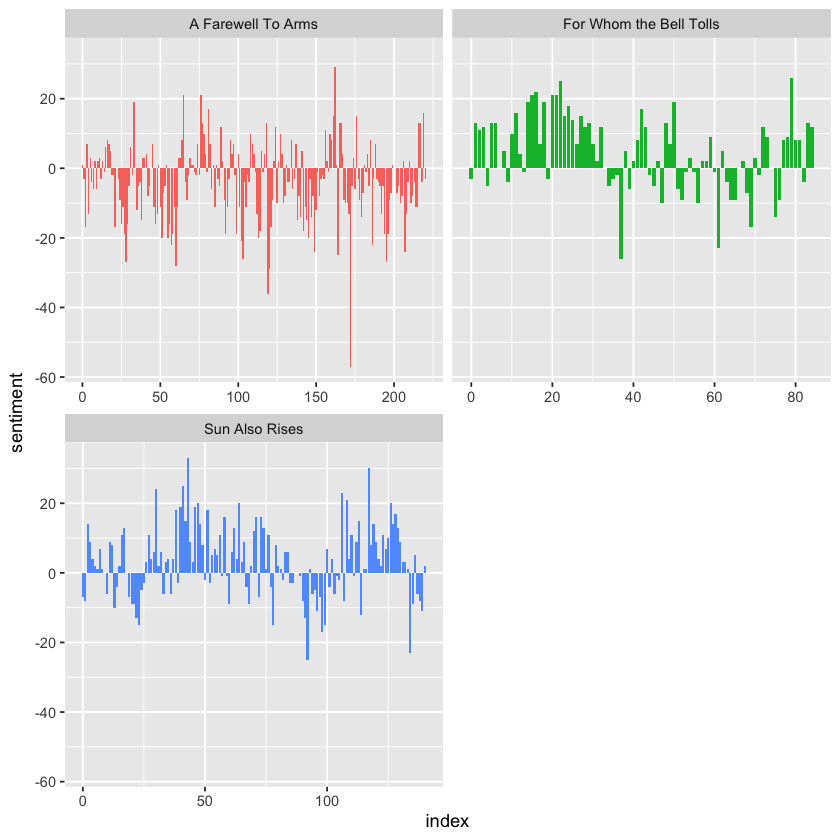

In [18]:
#how positive-negative emotions are shown in the text
ggplot(hemingway_senti_bing, aes(index, sentiment, fill = title)) +
  geom_col(show.legend = FALSE) +
  facet_wrap( ~ title, ncol = 2, scales = "free_x")

In [19]:
#lets now take a look at valence
emo <- as_tibble(read.csv("http://www.fizyka.pw.edu.pl/~julas/TEXT/lab/Ratings_Warriner_et_al.csv", stringsAsFactors = F))  %>% 
    select(word = Word, valence = V.Mean.Sum, arousal = A.Mean.Sum)

In [20]:
hemingway_senti_warriner <- hemingway_books %>%
  inner_join(emo) %>%
  group_by(title, index = linenumber %/% 80) %>%
  summarise(valence = mean(valence))

Joining, by = "word"
`summarise()` has grouped output by 'title'. You can override using the
`.groups` argument.


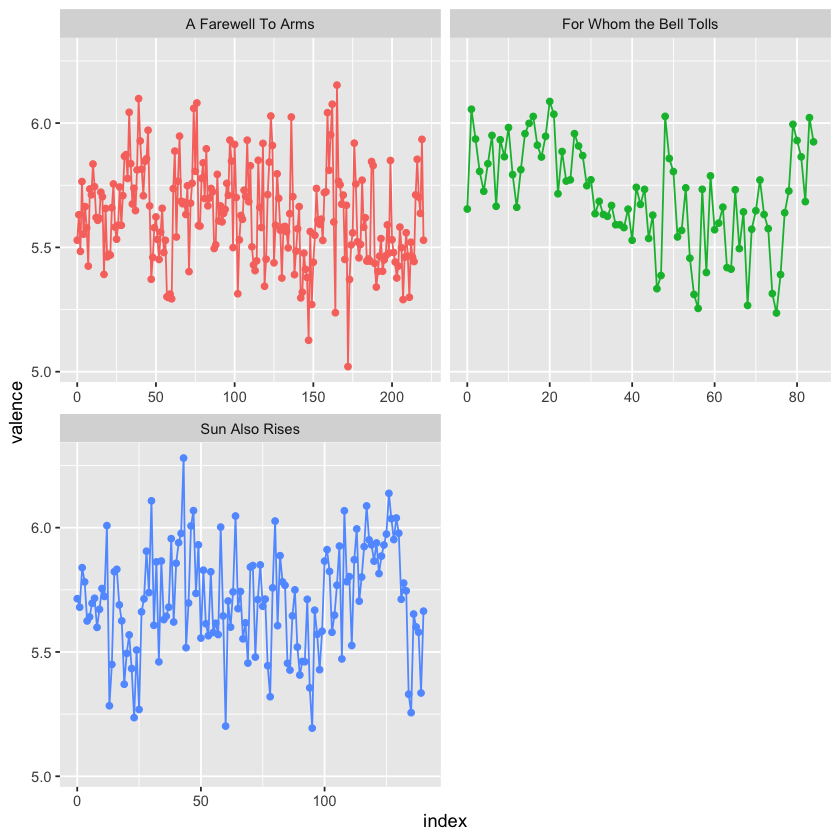

In [21]:
ggplot(hemingway_senti_warriner, aes(index, valence, color = title)) +
  geom_point(show.legend = FALSE) + 
  geom_line(show.legend = FALSE) +
  facet_wrap( ~ title, ncol = 2, scales = "free_x")

Joining, by = "word"


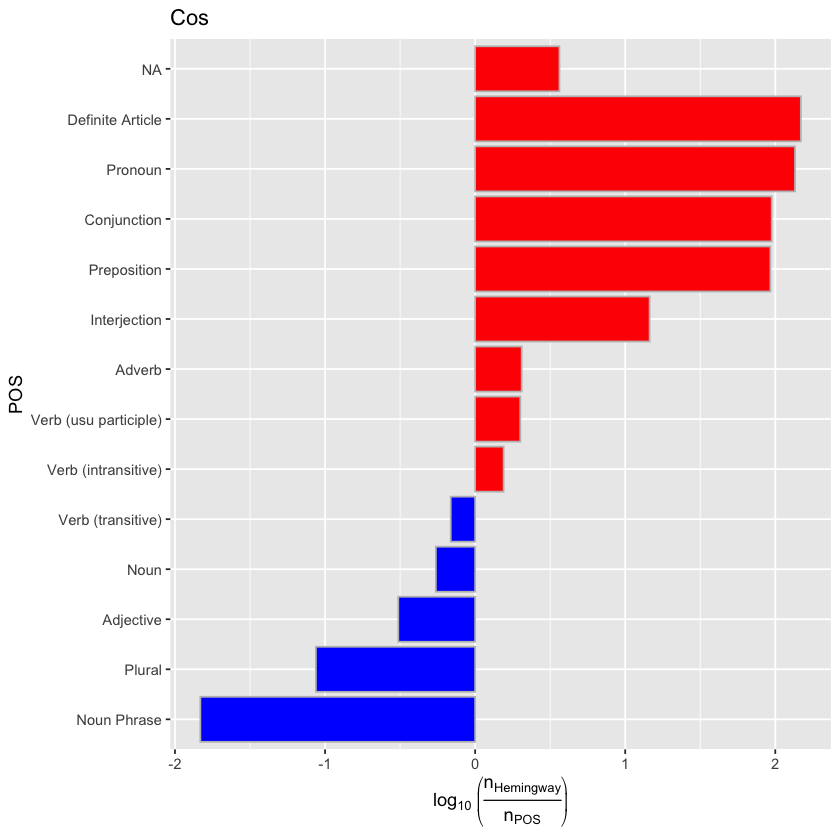

In [22]:
#lets also look at Parts of the Speech

pos <- parts_of_speech %>%
  count(pos, sort = T) %>%
  mutate(nn = n / sum(n))

hemingway_pos <- books %>%
  unnest_tokens(word, text) %>%
  left_join(parts_of_speech) %>%
  count(pos, sort = T) %>%
  mutate(nn = n / sum(n))

hemingway_join <- function(pos1, pos2){
    hemingway_join <- pos1 %>% 
      full_join(pos2, by = c("pos"))

    hemingway_join %>% 
      mutate(diff = log10(nn.x / nn.y)) %>% 
      ggplot() + geom_bar(aes(x = reorder(pos, diff), diff, fill = diff > 0), color = "grey", stat="identity") +
      scale_fill_manual(values = c("blue", "red")) + 
      coord_flip() + 
      theme(legend.position = "none")
      
    
}

hemingway_join(hemingway_pos, pos) +
    labs(title="Cos", x = "POS", y = expression(paste(log[10]," ",bgroup("(",frac(n[Hemingway],n[POS]),")"))))

In [23]:
#and differences between each book
posInBook <- function(book){
    book %>%
    unnest_tokens(word, text) %>%
    left_join(parts_of_speech) %>%
    count(pos, sort = T) %>%
    mutate(nn = n / sum(n))
}
hemingway_pos1 <- posInBook(book1)
hemingway_pos2 <- posInBook(book2)
hemingway_pos3 <- posInBook(book3)

Joining, by = "word"
Joining, by = "word"
Joining, by = "word"


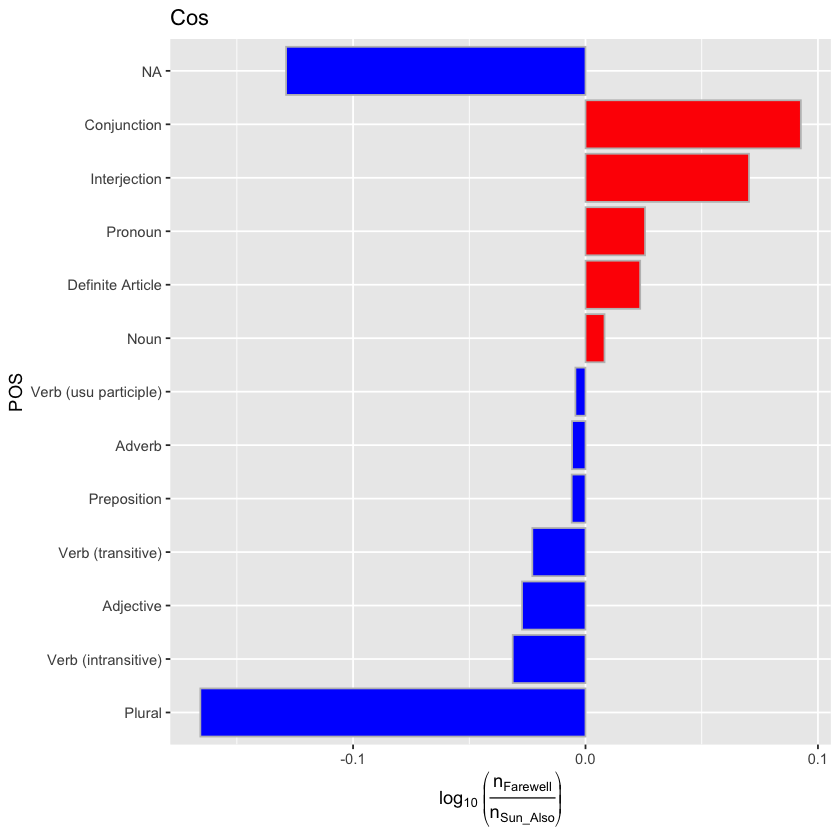

In [24]:
hemingway_join(hemingway_pos1, hemingway_pos2) +
    labs(title="Cos", x = "POS", y = expression(paste(log[10]," ",bgroup("(",frac(n[Farewell],n[Sun_Also]),")"))))

Warning message:
“Removed 1 rows containing missing values (`position_stack()`).”


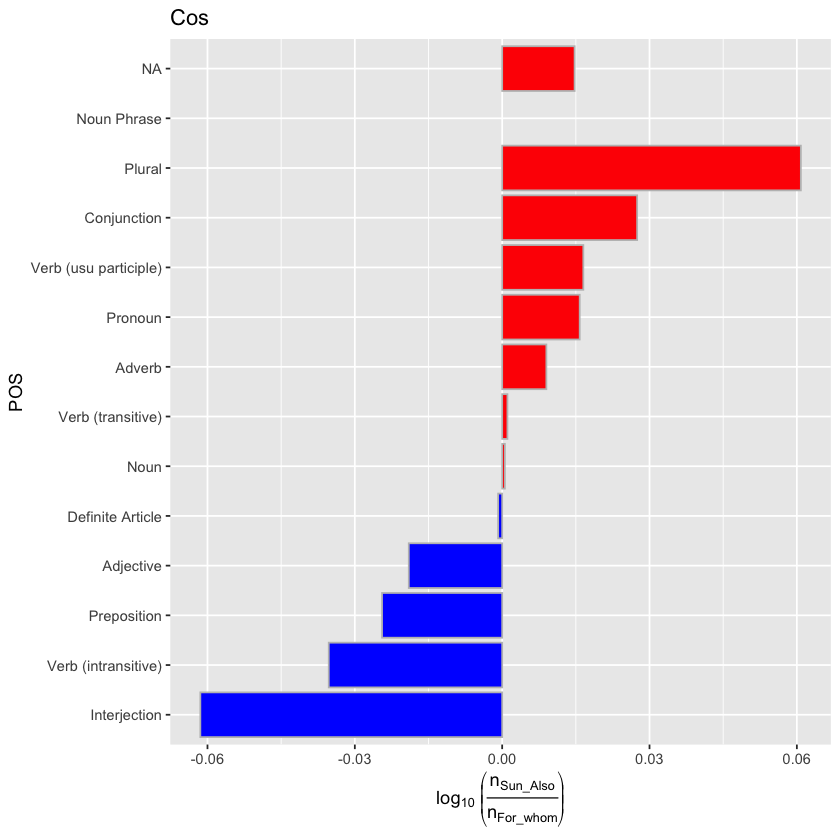

In [25]:
hemingway_join(hemingway_pos2, hemingway_pos3) +
    labs(title="Cos", x = "POS", y = expression(paste(log[10]," ",bgroup("(",frac(n[Sun_Also],n[For_whom]),")"))))

Warning message:
“Removed 1 rows containing missing values (`position_stack()`).”


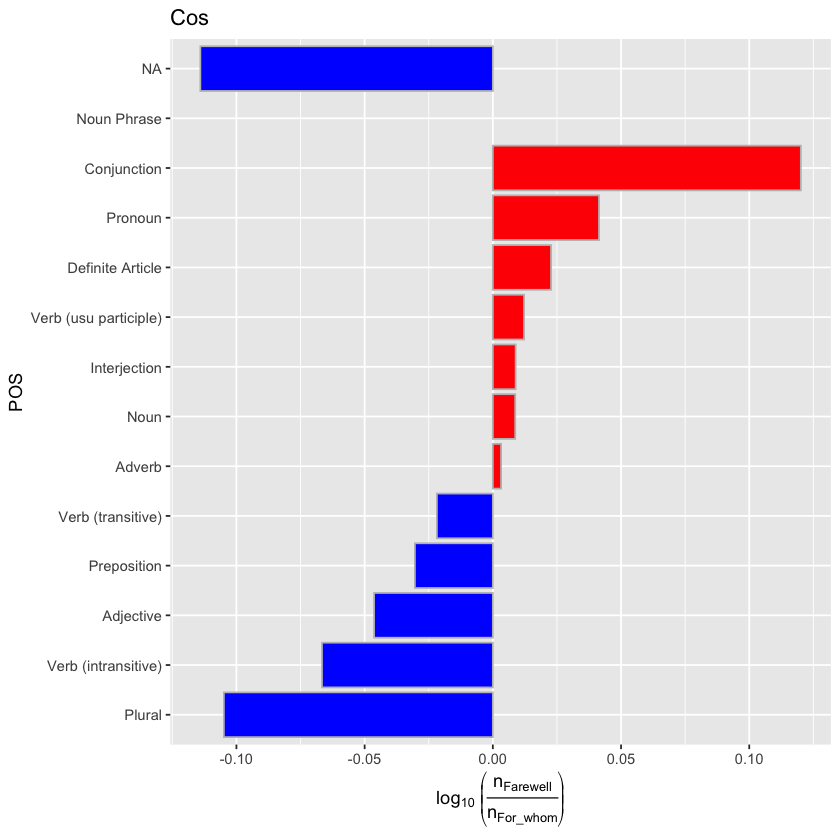

In [26]:
hemingway_join(hemingway_pos1, hemingway_pos3) +
    labs(title="Cos", x = "POS", y = expression(paste(log[10]," ",bgroup("(",frac(n[Farewell],n[For_whom]),")"))))